# StarDist

In [2]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from microfilm.microplot import microshow

[Stardist](https://github.com/mpicbg-csbd/stardist) is a segmentation tool able to separate even densely packed so-called star-convex objects (any point on the object boundary can be reached from a single point inside the object, see [here](https://en.wikipedia.org/wiki/Star_domain) for formal definition). Different models trained on different collections of nuclei images are available in this tool. However it can also be re-trained or fine-tuned by the user. **For a full description, check the GitHub repository and the great examples provided as notebooks.**

## Installation

The installation can be tricky, especially if you want to use a GPU. For this course, we only do inference for which CPU is sufficient. If you plan to do training on a computer with a GPU, you will have to follow the installation guide precisely, in particular to install the DL library TensorFlow. Here we just install the default CPU versions:

In [ ]:
pip install tensorflow -y

In [ ]:
pip install stardist -y

If you want to install StarDist on a Mac with M1 chip, follow [these instructions](https://forum.image.sc/t/napari-tensorflow-aicsimageio-stardist-care-n2v-pyclesperanto-running-native-on-apple-silicon-m1/55051/40?u=guiwitz).

## Pre-trained models

We will try to segment an image using the pre-trained network. If the image features are close enough to those found in the training set, we should be able to obtain a reasonable results. Here we first get a list of available models:

In [3]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


Then we import the necessary components from StarDist and instantiate one of the models:

In [4]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Metal device set to: Apple M1 Pro


2022-07-07 20:35:40.021804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-07 20:35:40.022088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


## Running inference

Now we are going to analyze one image from our dataset. These are 3D data and will take a projection. Note that these data are from the DBMR and have never been seen by the network.

In [34]:
from aicsimageio import AICSImage

image = AICSImage('../data/C_Ss_3D-LR40x.czi')

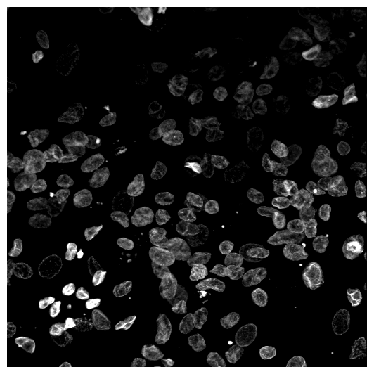

In [36]:
image_proj = image.data[0,0,:,:,:].max(axis=0)

microshow(image_proj, limits=[0,100], fig_scaling=5);

We see that the image is very crowded, with nuclei also of different intensities. To conform to the model expectations, we first normalize the image:

In [37]:
image_norm = normalize(image_proj)

And now we can run our model on our image. The output is simply a label image:

In [39]:
labels, _ = model.predict_instances(image_norm)

1/1 [==============================] - 0s 93ms/step


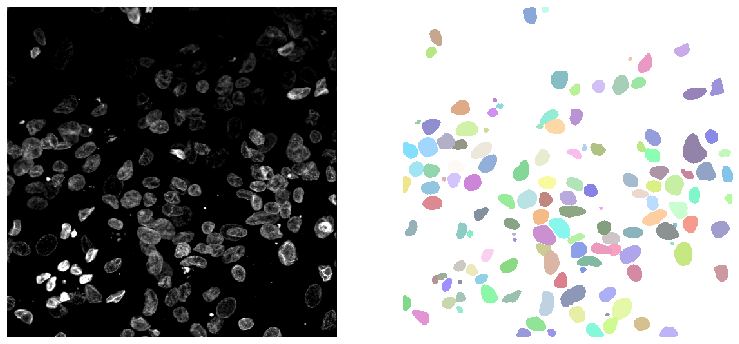

In [40]:
fig, ax = plt.subplots(1,2, figsize=(13,13))
microshow(image_proj, fig_scaling=5, ax=ax[0], limits=[0,100])
microshow(labels, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

As you can see, the network, **even without retraining**, does already a very good job at segmenting our image!

Let's try now with one of the image we analyzed previously:

In [47]:
import skimage

image = skimage.io.imread('../data/cellaltlas/19838_1252_F8_1.tiff')
image_nucl = image[:,:,2]
image_nucl_norm = normalize(image_nucl)

labels_nucl, _ = model.predict_instances(image_nucl_norm)

2022-07-07 20:55:04.018548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 786ms/step


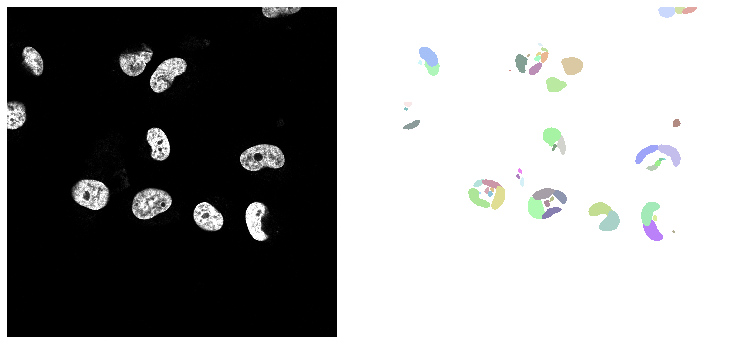

In [53]:
fig, ax = plt.subplots(1,2, figsize=(13,13))
microshow(image_nucl_norm, fig_scaling=5, ax=ax[0], limits=[0,1])
microshow(labels_nucl, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

Something strange happened: all our nuclei are split into smaller parts! The reason is that the Stardist model has been trained on image where nuclei have a certain size (in pixels). If we use now an image with much larger nuclei, the network will still look for smaller object and therefore split objects. There is no "clean" way around this problem. The only solutions we have here, is to rescale the image. For example we can take every 4th pixel:

In [50]:
image_nucl_norm_rescaled = image_nucl_norm[::4, ::4]
labels_nucl_rescaled, _ = model.predict_instances(image_nucl_norm_rescaled)

1/1 [==============================] - 0s 94ms/step


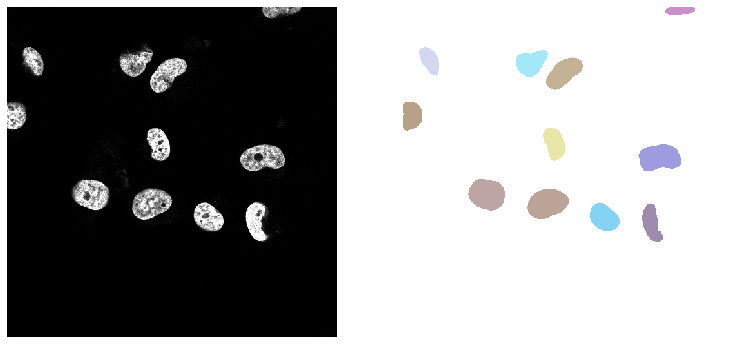

In [54]:
fig, ax = plt.subplots(1,2, figsize=(13,13))
microshow(image_nucl_norm_rescaled, fig_scaling=5, ax=ax[0], limits=[0,1])
microshow(labels_nucl_rescaled, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

Now we have an almost perfect results. This short example illustrates how **one should be cautious when re-using a pre-trained network**. In any case, manually annotate a few examples and show that the automated segmentation matches your expectations.

## Exercise

Try to segment again the image ```EmbryoTorax2D-HR.czi``` Remember that the result using simple thresholding was far from perfect.

Plot only a part of the image to check the segmentation. Is it good? If not what could be the problem and how could you fix this ?